In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
from torchvision import transforms as T

import matplotlib.pyplot as plt
import numpy as np

In [6]:
picProcessor = T.Compose([
    T.ToTensor(),
    T.Normalize(
        mean = [0.1 / 1.275],
        std = [1.0 / 1.275]
    ),
])

In [7]:
dataPath = "E:\\github\\CNN-models-reproduction\\LeNet\\dataset\\" 
mnistTrain = datasets.MNIST(dataPath, train = True,  download = False, transform = picProcessor)
mnistTest = datasets.MNIST(dataPath, train = False, download = False, transform = picProcessor)

In [8]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [9]:
class Subsampling(nn.Module):
    def __init__(self, in_channel):
        super(Subsampling,self).__init__()
        self.pool = nn.AvgPool2d(2)
        self.in_channel = in_channel
        F_in = 4 * self.in_channel
        self.weight = nn.Parameter(torch.rand(self.in_channel) * 4.8 / F_in - 2.4 / F_in, requires_grad=True)
        self.bias = nn.Parameter(torch.rand(self.in_channel), requires_grad=True)
    
    def forward(self, x):
        x = self.pool(x)
        outs = [] #对每一个channel的特征图进行池化，结果存储在这里

        for channel in range(self.in_channel):
            out = x[:, channel] * self.weight[channel] + self.bias[channel] #这一步计算每一个channel的池化结果[batch_size, height, weight]
            outs.append(out.unsqueeze(1)) #把channel的维度加进去[batch_size, channel, height, weight]
        return torch.cat(outs, dim = 1)

In [27]:
class MapConv(nn.Module):
    def __init__(self,in_channel, out_channel, kernel_size = 5):
        super(MapConv,self).__init__()
        mapInfo = [[1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1],
                   [1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1],
                   [1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1],
                   [0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1],
                   [0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1],
                   [0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1]]
        mapInfo = torch.tensor(mapInfo, dtype = torch.long)
        self.register_buffer("mapInfo", mapInfo) #在Module中的buffer中的参数是不会被求梯度的
        
        self.in_channel = in_channel
        self.out_channel = out_channel
        
        self.convs = {} #将每一个定义的卷积层都放进这个字典
        
        #对每一个新建立的卷积层都进行注册，使其真正成为模块并且方便调用
        for i in range(self.out_channel):
            conv = nn.Conv2d(mapInfo[:, i].sum().item(), 1, kernel_size)
            convName = "conv{}".format(i)
            self.convs[convName] = conv
            self.add_module(convName, conv)

    def forward(self, x):
        outs = [] #对每一个卷积层通过映射来计算卷积，结果存储在这里
        
        for i in range(self.out_channel):
            mapIdx = self.mapInfo[:, i].nonzero().squeeze()
            convInput = x.index_select(1, mapIdx)
            convOutput = self.convs['conv{}'.format(i)](convInput)
            outs.append(convOutput)
        return torch.cat(outs, dim = 1)


In [11]:
_zero = [-1, +1, +1, +1, +1, +1, -1] + \
        [-1, -1, -1, -1, -1, -1, -1] + \
        [-1, -1, +1, +1, +1, -1, -1] + \
        [-1, +1, +1, -1, +1, +1, -1] + \
        [+1, +1, -1, -1, -1, +1, +1] + \
        [+1, +1, -1, -1, -1, +1, +1] + \
        [+1, +1, -1, -1, -1, +1, +1] + \
        [+1, +1, -1, -1, -1, +1, +1] + \
        [-1, +1, +1, -1, +1, +1, -1] + \
        [-1, -1, +1, +1, +1, -1, -1] + \
        [-1, -1, -1, -1, -1, -1, -1] + \
        [-1, -1, -1, -1, -1, -1, -1]

_one = [-1, -1, -1, +1, +1, -1, -1] + \
       [-1, -1, +1, +1, +1, -1, -1] + \
       [-1, +1, +1, +1, +1, -1, -1] + \
       [-1, -1, -1, +1, +1, -1, -1] + \
       [-1, -1, -1, +1, +1, -1, -1] + \
       [-1, -1, -1, +1, +1, -1, -1] + \
       [-1, -1, -1, +1, +1, -1, -1] + \
       [-1, -1, -1, +1, +1, -1, -1] + \
       [-1, -1, -1, +1, +1, -1, -1] + \
       [-1, +1, +1, +1, +1, +1, +1] + \
       [-1, -1, -1, -1, -1, -1, -1] + \
       [-1, -1, -1, -1, -1, -1, -1]

_two = [-1, +1, +1, +1, +1, +1, -1] + \
       [-1, -1, -1, -1, -1, -1, -1] + \
       [-1, +1, +1, +1, +1, +1, -1] + \
       [+1, +1, -1, -1, -1, +1, +1] + \
       [+1, -1, -1, -1, -1, +1, +1] + \
       [-1, -1, -1, -1, +1, +1, -1] + \
       [-1, -1, +1, +1, +1, -1, -1] + \
       [-1, +1, +1, -1, -1, -1, -1] + \
       [+1, +1, -1, -1, -1, -1, -1] + \
       [+1, +1, +1, +1, +1, +1, +1] + \
       [-1, -1, -1, -1, -1, -1, -1] + \
       [-1, -1, -1, -1, -1, -1, -1]

_three = [+1, +1, +1, +1, +1, +1, +1] + \
         [-1, -1, -1, -1, -1, +1, +1] + \
         [-1, -1, -1, -1, +1, +1, -1] + \
         [-1, -1, -1, +1, +1, -1, -1] + \
         [-1, -1, +1, +1, +1, +1, -1] + \
         [-1, -1, -1, -1, -1, +1, +1] + \
         [-1, -1, -1, -1, -1, +1, +1] + \
         [-1, -1, -1, -1, -1, +1, +1] + \
         [+1, +1, -1, -1, -1, +1, +1] + \
         [-1, +1, +1, +1, +1, +1, -1] + \
         [-1, -1, -1, -1, -1, -1, -1] + \
         [-1, -1, -1, -1, -1, -1, -1]

_four = [-1, +1, +1, +1, +1, +1, -1] + \
        [-1, -1, -1, -1, -1, -1, -1] + \
        [-1, -1, -1, -1, -1, -1, -1] + \
        [-1, +1, +1, -1, -1, +1, +1] + \
        [-1, +1, +1, -1, -1, +1, +1] + \
        [+1, +1, +1, -1, -1, +1, +1] + \
        [+1, +1, -1, -1, -1, +1, +1] + \
        [+1, +1, -1, -1, -1, +1, +1] + \
        [+1, +1, -1, -1, +1, +1, +1] + \
        [-1, +1, +1, +1, +1, +1, +1] + \
        [-1, -1, -1, -1, -1, +1, +1] + \
        [-1, -1, -1, -1, -1, +1, +1]

_five = [-1, +1, +1, +1, +1, +1, -1] + \
        [-1, -1, -1, -1, -1, -1, -1] + \
        [+1, +1, +1, +1, +1, +1, +1] + \
        [+1, +1, -1, -1, -1, -1, -1] + \
        [+1, +1, -1, -1, -1, -1, -1] + \
        [-1, +1, +1, +1, +1, -1, -1] + \
        [-1, -1, +1, +1, +1, +1, -1] + \
        [-1, -1, -1, -1, -1, +1, +1] + \
        [+1, +1, -1, -1, -1, +1, +1] + \
        [-1, +1, +1, +1, +1, +1, -1] + \
        [-1, -1, -1, -1, -1, -1, -1] + \
        [-1, -1, -1, -1, -1, -1, -1]

_six = [-1, -1, +1, +1, +1, +1, -1] + \
       [-1, +1, +1, -1, -1, -1, -1] + \
       [+1, +1, -1, -1, -1, -1, -1] + \
       [+1, +1, -1, -1, -1, -1, -1] + \
       [+1, +1, +1, +1, +1, +1, -1] + \
       [+1, +1, +1, -1, -1, +1, +1] + \
       [+1, +1, -1, -1, -1, +1, +1] + \
       [+1, +1, -1, -1, -1, +1, +1] + \
       [+1, +1, +1, -1, -1, +1, +1] + \
       [-1, +1, +1, +1, +1, +1, -1] + \
       [-1, -1, -1, -1, -1, -1, -1] + \
       [-1, -1, -1, -1, -1, -1, -1]

_seven = [+1, +1, +1, +1, +1, +1, +1] + \
         [-1, -1, -1, -1, -1, +1, +1] + \
         [-1, -1, -1, -1, -1, +1, +1] + \
         [-1, -1, -1, -1, +1, +1, -1] + \
         [-1, -1, -1, +1, +1, -1, -1] + \
         [-1, -1, -1, +1, +1, -1, -1] + \
         [-1, -1, +1, +1, -1, -1, -1] + \
         [-1, -1, +1, +1, -1, -1, -1] + \
         [-1, -1, +1, +1, -1, -1, -1] + \
         [-1, -1, +1, +1, -1, -1, -1] + \
         [-1, -1, -1, -1, -1, -1, -1] + \
         [-1, -1, -1, -1, -1, -1, -1]

_eight = [-1, +1, +1, +1, +1, +1, -1] + \
         [+1, +1, -1, -1, -1, +1, +1] + \
         [+1, +1, -1, -1, -1, +1, +1] + \
         [+1, +1, -1, -1, -1, +1, +1] + \
         [-1, +1, +1, +1, +1, +1, -1] + \
         [+1, +1, -1, -1, -1, +1, +1] + \
         [+1, +1, -1, -1, -1, +1, +1] + \
         [+1, +1, -1, -1, -1, +1, +1] + \
         [+1, +1, -1, -1, -1, +1, +1] + \
         [-1, +1, +1, +1, +1, +1, -1] + \
         [-1, -1, -1, -1, -1, -1, -1] + \
         [-1, -1, -1, -1, -1, -1, -1]

_nine = [-1, +1, +1, +1, +1, +1, -1] + \
        [+1, +1, -1, -1, +1, +1, +1] + \
        [+1, +1, -1, -1, -1, +1, +1] + \
        [+1, +1, -1, -1, -1, +1, +1] + \
        [+1, +1, -1, -1, +1, +1, +1] + \
        [-1, +1, +1, +1, +1, +1, +1] + \
        [-1, -1, -1, -1, -1, +1, +1] + \
        [-1, -1, -1, -1, -1, +1, +1] + \
        [-1, -1, -1, -1, +1, +1, -1] + \
        [-1, +1, +1, +1, +1, -1, -1] + \
        [-1, -1, -1, -1, -1, -1, -1] + \
        [-1, -1, -1, -1, -1, -1, -1]


RBF_WEIGHT = np.array([_zero, _one, _two, _three, _four, _five, _six, _seven, _eight, _nine]).transpose()

class RBFLayer(nn.Module):
    def __init__(self, in_features, out_features, init_weight = None):
        super(RBFLayer, self).__init__()
        if init_weight is not None:
            self.register_buffer("weight", torch.tensor(init_weight))
        else:
            self.register_buffer("weight", torch.rand(in_features, out_features))
            
    def forward(self, x):
        x = x.unsqueeze(-1)
        x = (x - self.weight).pow(2).sum(-2)
        return x


In [25]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.C1 = nn.Conv2d(1, 6, 5, padding = 2, padding_mode = 'replicate')
        self.S2 = Subsampling(6)
        self.C3 = MapConv(6, 16, 5)
        self.S4 = Subsampling(16)
        self.C5 = nn.Conv2d(16, 120, 5)
        self.F6 = nn.Linear(120, 84)
        self.Output = RBFLayer(84, 10, RBF_WEIGHT)
        
        self.act = nn.Tanh()
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                F_in = m.kernel_size[0] * m.kernel_size[1] * m.in_channels
                m.weight.data = torch.rand(m.weight.data.size()) * 4.8 / F_in - 2.4 / F_in
            elif isinstance(m, nn.Linear):
                F_in = m.in_features
                m.weight.data = torch.rand(m.weight.data.size()) * 4.8 / F_in - 2.4 / F_in
    
    def forward(self, x):
        x = self.C1(x)
        x = 1.7159 * self.act(2 * self.S2(x) / 3)
        x = self.C3(x)
        x = 1.7159 * self.act(2 * self.S4(x) / 3)
        x = self.C5(x)
        
        x = x.view(-1, 120)
        
        x = 1.7159 * self.act(2 * self.F6(x) / 3)
        
        out = self.Output(x)
        return out


In [13]:
def loss_fn(pred, label):
    if(label.dim() == 1):
        return pred[torch.arange(pred.size(0)), label]
    else:
        return pred[torch.arange(pred.size(0)), label.squeeze()]

In [31]:
lossList = []
testError = []
trainError = []
def train(epochs, model, optimizer, scheduler: bool, loss_fn, trainSet, testSet):

    trainNum = len(trainSet)
    testNum = len(testSet)
    for epoch in range(epochs):
        lossSum = 0.0
        print("epoch: {:02d} / {:d}".format(epoch+1, epochs))
        
        for idx, (img, label) in enumerate(trainSet):
            
            x = img.unsqueeze(0).to(device)
            y = torch.tensor([label], dtype = torch.long).to(device)
            
            out = model(x)
            optimizer.zero_grad()
            loss = loss_fn(out, y)
            loss.backward()
            optimizer.step()
            
            lossSum += loss.item()
            if (idx + 1) % 2000 == 0: print("sample: {:05d} / {:d} --> loss: {:.4f}".format(idx+1, trainNum, loss.item()))
        
        lossList.append(lossSum / trainNum)
        
        with torch.no_grad():
            errorNum = 0
            for img, label in trainSet:
                x = img.unsqueeze(0).to(device)
                out = model(x)
                _, pred_y = out.min(dim = 1)
                if(pred_y != label): errorNum += 1
            trainError.append(errorNum / trainNum)
            
            errorNum = 0
            for img, label in testSet:
                x = img.unsqueeze(0).to(device)
                out = model(x)
                _, pred_y = out.min(dim = 1)
                if(pred_y != label): errorNum += 1
            testError.append(errorNum / testNum)
        
        if scheduler == True:
            if epoch < 5:
                for param_group in optimizer.param_groups:
                    param_group['lr'] = 1.0e-3
            elif epoch < 10:
                for param_group in optimizer.param_groups:
                    param_group['lr'] = 5.0e-4
            elif epoch < 15:
                for param_group in optimizer.param_groups:
                    param_group['lr'] = 2.0e-4
            else:
                for param_group in optimizer.param_groups:
                    param_group['lr'] = 1.0e-4

    torch.save(model.state_dict(), 'E:\\github\\CNN-models-reproduction\\LeNet\\5epoch-{:d}_loss-{:.6f}_error-{:.2%}.pth'.format(epochs, lossList[-1], testError[-1]))


epoch: 01 / 25
sample: 02000 / 60000 --> loss: 50.4780
sample: 04000 / 60000 --> loss: 45.3264
sample: 06000 / 60000 --> loss: 50.1763
sample: 08000 / 60000 --> loss: 61.2208
sample: 10000 / 60000 --> loss: 75.8370
sample: 12000 / 60000 --> loss: 48.7051
sample: 14000 / 60000 --> loss: 47.3273
sample: 16000 / 60000 --> loss: 79.6415
sample: 18000 / 60000 --> loss: 44.4480
sample: 20000 / 60000 --> loss: 57.5230
sample: 22000 / 60000 --> loss: 55.7501
sample: 24000 / 60000 --> loss: 61.5074
sample: 26000 / 60000 --> loss: 49.0858
sample: 28000 / 60000 --> loss: 45.4849
sample: 30000 / 60000 --> loss: 84.0638
sample: 32000 / 60000 --> loss: 46.5164
sample: 34000 / 60000 --> loss: 50.3390
sample: 36000 / 60000 --> loss: 48.9910
sample: 38000 / 60000 --> loss: 74.4047
sample: 40000 / 60000 --> loss: 46.4023
sample: 42000 / 60000 --> loss: 50.9585
sample: 44000 / 60000 --> loss: 48.9884
sample: 46000 / 60000 --> loss: 82.8445
sample: 48000 / 60000 --> loss: 53.5194
sample: 50000 / 60000 -->

sample: 54000 / 60000 --> loss: 25.8932
sample: 56000 / 60000 --> loss: 3.6168
sample: 58000 / 60000 --> loss: 2.8664
sample: 60000 / 60000 --> loss: 7.4816
epoch: 08 / 25
sample: 02000 / 60000 --> loss: 15.1177
sample: 04000 / 60000 --> loss: 2.4527
sample: 06000 / 60000 --> loss: 2.2669
sample: 08000 / 60000 --> loss: 1.1754
sample: 10000 / 60000 --> loss: 2.2673
sample: 12000 / 60000 --> loss: 14.4091
sample: 14000 / 60000 --> loss: 1.9182
sample: 16000 / 60000 --> loss: 5.2432
sample: 18000 / 60000 --> loss: 3.6879
sample: 20000 / 60000 --> loss: 2.1331
sample: 22000 / 60000 --> loss: 0.6832
sample: 24000 / 60000 --> loss: 1.6626
sample: 26000 / 60000 --> loss: 0.4316
sample: 28000 / 60000 --> loss: 4.0555
sample: 30000 / 60000 --> loss: 2.9162
sample: 32000 / 60000 --> loss: 2.1647
sample: 34000 / 60000 --> loss: 1.7129
sample: 36000 / 60000 --> loss: 2.7208
sample: 38000 / 60000 --> loss: 1.9080
sample: 40000 / 60000 --> loss: 5.6973
sample: 42000 / 60000 --> loss: 24.9092
sample

sample: 48000 / 60000 --> loss: 1.6507
sample: 50000 / 60000 --> loss: 2.9627
sample: 52000 / 60000 --> loss: 2.0140
sample: 54000 / 60000 --> loss: 35.3629
sample: 56000 / 60000 --> loss: 1.2705
sample: 58000 / 60000 --> loss: 2.4020
sample: 60000 / 60000 --> loss: 3.8847
epoch: 15 / 25
sample: 02000 / 60000 --> loss: 9.7685
sample: 04000 / 60000 --> loss: 1.2645
sample: 06000 / 60000 --> loss: 1.1254
sample: 08000 / 60000 --> loss: 0.9563
sample: 10000 / 60000 --> loss: 1.5871
sample: 12000 / 60000 --> loss: 16.4277
sample: 14000 / 60000 --> loss: 1.5058
sample: 16000 / 60000 --> loss: 4.8920
sample: 18000 / 60000 --> loss: 3.2319
sample: 20000 / 60000 --> loss: 1.2270
sample: 22000 / 60000 --> loss: 0.5148
sample: 24000 / 60000 --> loss: 1.8496
sample: 26000 / 60000 --> loss: 0.4068
sample: 28000 / 60000 --> loss: 2.8793
sample: 30000 / 60000 --> loss: 1.6421
sample: 32000 / 60000 --> loss: 2.1885
sample: 34000 / 60000 --> loss: 0.6786
sample: 36000 / 60000 --> loss: 2.7817
sample: 

sample: 42000 / 60000 --> loss: 10.6000
sample: 44000 / 60000 --> loss: 1.2311
sample: 46000 / 60000 --> loss: 0.1369
sample: 48000 / 60000 --> loss: 1.7251
sample: 50000 / 60000 --> loss: 2.9545
sample: 52000 / 60000 --> loss: 1.8668
sample: 54000 / 60000 --> loss: 36.9623
sample: 56000 / 60000 --> loss: 0.6935
sample: 58000 / 60000 --> loss: 2.0717
sample: 60000 / 60000 --> loss: 3.0899
epoch: 22 / 25
sample: 02000 / 60000 --> loss: 8.5581
sample: 04000 / 60000 --> loss: 1.2594
sample: 06000 / 60000 --> loss: 1.1221
sample: 08000 / 60000 --> loss: 0.9939
sample: 10000 / 60000 --> loss: 1.2235
sample: 12000 / 60000 --> loss: 15.5459
sample: 14000 / 60000 --> loss: 1.6205
sample: 16000 / 60000 --> loss: 4.8120
sample: 18000 / 60000 --> loss: 3.2005
sample: 20000 / 60000 --> loss: 1.6239
sample: 22000 / 60000 --> loss: 0.5317
sample: 24000 / 60000 --> loss: 1.5382
sample: 26000 / 60000 --> loss: 0.7682
sample: 28000 / 60000 --> loss: 1.9476
sample: 30000 / 60000 --> loss: 1.3256
sample:

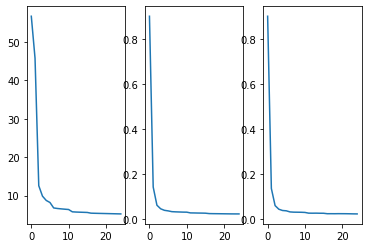

In [32]:
if __name__ == '__main__':

    model = LeNet5().to(device)
    optimizer = optim.SGD(model.parameters(), lr = 1.0e-3)
    
    scheduler = True
    
    epochs = 25
    
    train(epochs, model, optimizer, scheduler, loss_fn, mnistTrain, mnistTest)
    plt.subplot(1, 3, 1)
    plt.plot(lossList)
    plt.subplot(1, 3, 2)
    plt.plot(trainError)
    plt.subplot(1, 3 ,3)
    plt.plot(testError)
    plt.show()